In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.utils import resample

In [3]:
X_train=pd.read_csv('/Users/zuza/Desktop/X_train.csv')

In [4]:
X_train.head()

,time,seconds_elapsed_orientation,qz_orientation,qy_orientation,qx_orientation,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,seconds_elapsed_location,...,horizontalAccuracy_location_network,speed_location_network,bearing_location_network,altitude_location_network,longitude_location_network,latitude_location_network,seconds_elapsed_gravity,z_gravity,y_gravity,x_gravity
0,1694857537318869200,1228.074843,-0.626221,0.386100,-0.674631,0.060399,-1.826153,0.600508,-2.571477,1228.069,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,1228.074843,-2.041392,-5.524593,7.841044
1,1694857182616775700,873.374776,-0.013953,-0.618994,-0.425122,0.660245,-1.723670,0.575310,0.706575,873.070,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,873.374776,-1.252387,-5.323759,8.139995
2,1694850675496257000,488.368257,0.529413,-0.843842,0.045404,0.074776,-2.755124,1.090140,-0.343697,488.191,...,800.000000,0.0,0.0,0.0,3.123176,50.672179,488.368257,-4.202703,-8.689218,1.733541
3,1694856574973923600,265.731924,-0.103478,-0.568592,-0.501415,0.643878,-1.747675,0.556275,0.976151,265.072,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,265.731924,-1.467729,-5.174577,8.199995
4,1697611168928672300,191.401327,-0.176786,0.565639,-0.799976,0.094012,-2.952015,0.358007,-1.945084,191.092,...,34.563000,0.0,0.0,90.5,3.132056,50.687971,191.401327,-9.001679,-3.482618,1.735401


In [5]:
#  We identified outliers in the following columns during Exploratory Data Analysis (EDA):
#  ['speedAccuracy_location', 'vertical_accuracy_location_network', 'horizontalAccuracy_location',
#  'verticalAccuracy_location', 'speed_location', 'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
#  'horizontalAccuracy_location_gps', 'atitude_location_gps', 'verticalAccuracy_location_network',
#  'horizontalAccuracy_location_network', 'atitude_location_network'].
#  We'll replace these outliers with the median value for each respective column.

class OutlierHandlerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data_to_transform = X[self.columns]
        transformed_data = self.imputer.fit_transform(data_to_transform)
        X[self.columns] = transformed_data
        return X

In [6]:
# Since it was observed through exploratory data analysis (EDA) that columns related to elapsed time are similar, 
# we want to consolidate them by calculating their mean value. This transformer computes the average of the elapsed time
# values and removes the individual columns to avoid redundant information.

class AverageSecondsElapsedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='seconds_elapsed_'):
        self.keyword = keyword
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['seconds_elapsed_time'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [7]:
len(X_train['seconds_elapsed_pedometer'].loc[X_train['seconds_elapsed_pedometer']<0])/len(X_train)

0.19810154013398834

In [8]:
# We have decided to drop the seconds_elapsed_time_pedometer column from our dataset. This decision is based on 
# the fact that 20% of its values are negative, and we are uncertain about the cause (possibly a device issue or a time shift). 
# Since we have other columns capturing elapsed time, we can safely remove this problematic column.

# Additionally, we will use a transformer to drop columns that contain only a single unique value, as they do not 
# provide any useful information for our model. We will also drop the original time column after extracting relevant time features from it.

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            X = X.drop(columns=self.columns, errors='ignore')
        return X

In [9]:
# Since we already have roll, pitch and yaw orientation values
# we do not need to convert quaterions (qx, qy, qz, qw) to Euler angles.

In [10]:
# Adding time features to capture the hour and minute of the day, which may be relevant for detecting patterns
# in the data. Since we are extracting time features, we will drop the original time column, which serves a role
# in our dataset similar to primary key.

class TimeFeatureExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['time'] = pd.to_datetime(X['time'], unit='ns')
        X['hour'] = X['time'].dt.hour
        X['minute'] = X['time'].dt.minute
        return X

In [11]:
# Based on our exploratory data analysis (EDA), we have identified that there are columns containing speed values. 
# We can reasonably assume that these speed-related columns will be among the most important features for our clasterization activity model.

X_train['speed_location_gps'].corr(X_train['speed_location'])

0.9808731877586917

In [12]:
# xGPS data tends to offer higher accuracy as it relies on satellite signals. However, its precision may fluctuate 
# due to atmospheric conditions or terrain. On the other hand, location data can be more reliable in areas where 
# GPS signals are inaccessible, such as indoors or in regions with poor signal coverage.

X_train[['speed_location_gps', 'speed_location']].loc[X_train['speed_location_gps']!=X_train['speed_location']]

,speed_location_gps,speed_location
0,6.602857,6.583204
1,5.193032,5.214794
2,4.892950,4.993772
3,5.824082,5.807374
4,6.181814,6.133829
...,...,...
1543562,0.000000,0.835902
1543563,0.800908,0.854354
1543564,3.083701,2.689046
1543565,0.949663,1.058741


In [13]:
print(X_train['speed_location_gps'].describe(), X_train['speed_location'].describe())

count    1.543567e+06
mean     2.987227e+00
std      2.745493e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.486108e+00
75%      5.497233e+00
max      1.074791e+01
Name: speed_location_gps, dtype: float64 count    1.543567e+06
mean     3.040514e+00
std      2.700369e+00
min      0.000000e+00
25%      2.457211e-01
50%      2.538605e+00
75%      5.501579e+00
max      1.514773e+01
Name: speed_location, dtype: float64


In [14]:
len(X_train['speed_location_gps']==0), len(X_train['speed_location']==0)

(1543567, 1543567)

In [15]:
# After careful analysis of these two variables, considering their relatively minor discrepancies,
#  we've opted to compute a simple mean of these columns and consolidate them into a single column named 'speed'.

class AverageSpeedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='speed_location'):
        self.keyword = keyword
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['seconds_elapsed_time'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [16]:
# Finally, we will standardize the features, including geographical coordinates, as our area is small, 
# making Euclidean distance appropriate for our purposes.

# Additionally, we'll utilize a custom standard scaler to preserve the structure of the DataFrame.

class PandasStandardScaler(StandardScaler):
    def fit_transform(self, X, y=None):
        scaled_data = super().fit_transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

In [17]:
pipeline = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network"])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_tranformer', AverageSpeedTransformer()),
    ('time_feature_extractor', TimeFeatureExtraction()),
    ('time_dropper', ColumnDropper(columns=['time'])),
    ('scaler', PandasStandardScaler())
])

In [18]:
X_train_transformed = pipeline.fit_transform(X_train)

In [19]:
X_train_transformed.head()

,qz_orientation,qy_orientation,qx_orientation,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,...,horizontalAccuracy_location_network,altitude_location_network,longitude_location_network,latitude_location_network,z_gravity,y_gravity,x_gravity,seconds_elapsed_time,hour,minute
0,-1.922989,1.270178,-0.901665,-1.183604,-0.061553,-0.053867,-1.187582,-0.244330,-0.007997,0.062353,...,-0.163827,0.138817,-1.000235,-0.407010,0.647006,-0.133540,1.041539,1.320782,-0.193806,0.662358
1,-0.263355,-0.735038,-0.497439,1.577629,0.002335,-0.102818,0.677356,-0.173736,0.072607,0.027813,...,-0.163827,0.138817,-1.000235,-0.407010,0.894836,-0.080482,1.124494,0.808170,-0.193806,0.225030
2,1.209515,-1.183621,0.264854,-1.117423,-0.640670,0.897339,0.079839,0.194678,1.523495,0.096893,...,1.959875,-1.993338,0.257729,-2.170860,-0.031871,-0.969594,-0.653198,0.712021,-0.617873,1.099686
3,-0.506024,-0.634483,-0.621040,1.502288,-0.012630,-0.139797,0.830722,-0.224476,-0.007997,0.161038,...,-0.163827,0.138817,-1.000235,-0.407010,0.827197,-0.041070,1.141143,1.033942,-0.193806,-0.503850
4,-0.704736,1.628369,-1.104734,-1.028878,-0.763412,-0.524971,-0.831216,-0.394343,-0.975255,-0.525402,...,-0.539449,0.908317,0.696426,0.934078,-1.539252,0.405924,-0.652682,1.160181,-0.829907,0.225030


In [20]:
X_train_transformed.columns

Index(['qz_orientation', 'qy_orientation', 'qx_orientation', 'qw_orientation',
       'roll_orientation', 'pitch_orientation', 'yaw_orientation',
       'bearingAccuracy_location', 'speedAccuracy_location',
       'verticalAccuracy_location', 'horizontalAccuracy_location',
       'bearing_location', 'altitude_location', 'longitude_location',
       'latitude_location', 'z_total_acceleration', 'y_total_acceleration',
       'x_total_acceleration', 'z_magnetometer', 'y_magnetometer',
       'x_magnetometer', 'z_accelerometer', 'y_accelerometer',
       'x_accelerometer', 'bearingAccuracy_location_gps',
       'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'altitude_location_gps', 'longitude_location_gps',
       'latitude_location_gps', 'z_gyroscope', 'y_gyroscope', 'x_gyroscope',
       'steps_pedometer', 'verticalAccuracy_location_network',
       'horizontalAccuracy_location_network', 'altitude_lo

In [21]:
len(X_train_transformed.columns)

47

## PCA

In [22]:
# PCA for 1 component

pca = PCA(n_components=1)
pca.fit(X_train_transformed)

PCA(n_components=1)

In [23]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')

print(f'Explained variance: {pca.explained_variance_[0]:.4f}')

print(pca.explained_variance_ratio_)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Total variance: 1.0000
Explained variance: 11.2640
[0.23965901]


In [24]:
# PCA for 2 components

pca2 = PCA(n_components=2)
principal_components = pca2.fit_transform(X_train_transformed)

In [25]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')

print(f'Explained variance: {pca2.explained_variance_[0]:.4f}')

print(pca2.explained_variance_ratio_)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Total variance: 1.0000
Explained variance: 11.2640
[0.23965901 0.12692186]


In [26]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

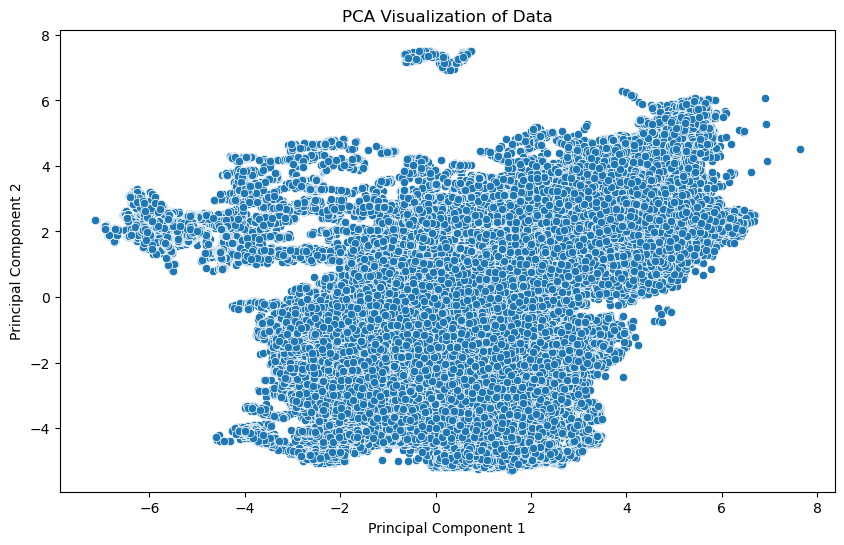

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [28]:
# PCA for 3 components

pca3 = PCA(n_components=3)
principal_components = pca3.fit_transform(X_train_transformed)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

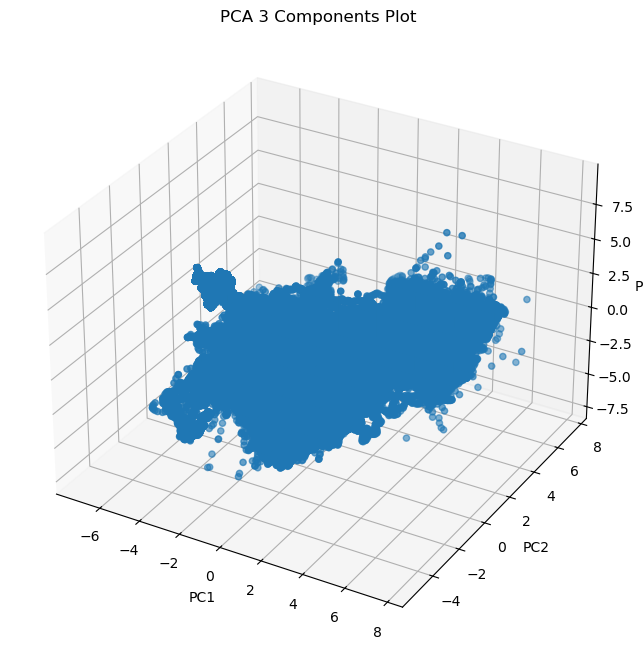

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3 Components Plot')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

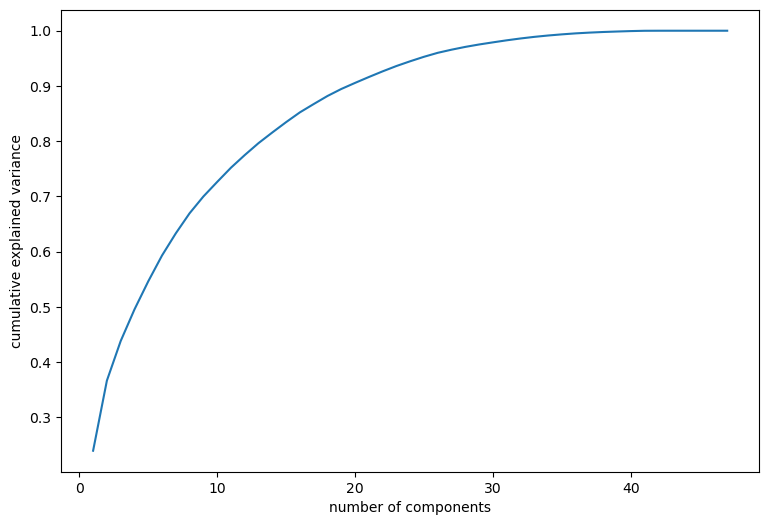

In [30]:
pca = PCA().fit(X_train_transformed)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## TSNE

In [35]:
def scatter_tsne(x):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    unique_colors = np.linspace(0, 1, len(x))
    palette = plt.cm.rainbow(unique_colors)

    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette)

    plt.xlim(np.min(x[:,0])-0.1, np.max(x[:,0])+0.1)
    plt.ylim(np.min(x[:,1])-0.1, np.max(x[:,1])+0.1)
    
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

In [39]:
%%time

X_train_transformed_sample = resample(X_train_transformed, n_samples=100000, random_state=42)

tSNE = TSNE(random_state=42, verbose=1)
digits_proj_sample = tSNE.fit_transform(X_train_transformed_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.009s...
[t-SNE] Computed neighbors for 100000 samples in 9.896s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probabi

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x15d473dd0>)

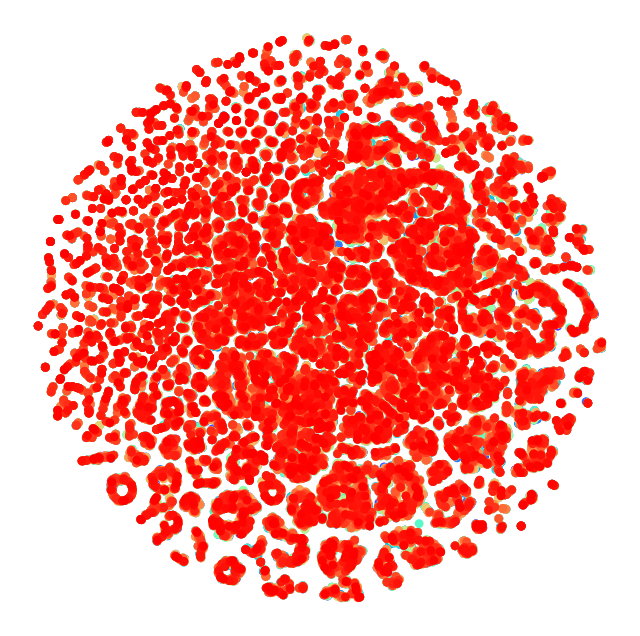

In [40]:
scatter_tsne(digits_proj_sample)